## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import keras.backend as K

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from lr_utils.keras_LRFinder import LRFinder
from lr_utils.keras_SGDR import SGDR
from lr_utils.keras_CLR import CyclicLR, CLR

/Users/abielski/anaconda/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load the dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [3]:
num_classes = 10
batch_size = 128
epochs=5

In [4]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Create a Network

The loss function has to be **categorical_crossentropy** since we deal with categorical labels.
The same goes for the last activation which has to be **softmax** since we have more than two classes (sigmoid would be fine for two classes).

In [5]:
def Net():

    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

    return model

In [6]:
model = Net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


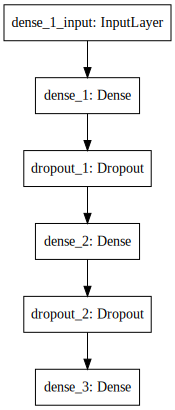

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Find the optimal Learning Rate

This method has been proposed by Leslie Smith. The concept to find the best learning rate is to begin at a small one, and increase it progressively. By looking at the loss function for the values of the Learning Rate, we can see it being very stable (no improvement) when the LR is small, then drop faster and faster and finally oscillate and diverge when the LR is too big. The optimal LR stands in the middle, where the slope is the steepest (not at the minimum of the curve).

In [8]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-2, step_size=np.ceil(X_train.shape[0]/batch_size))
model.fit(X_train, y_train, callbacks=[lr_finder] )

Epoch 1/1
22912/60000 [==========>...................] - ETA: 16s - loss: 2.0137 - acc: 0.3428

Raw loss values

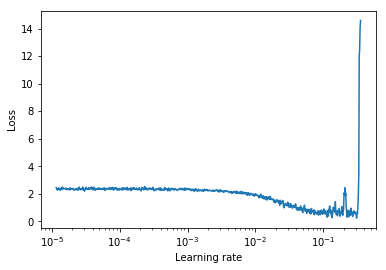

In [9]:
lr_finder.plot_loss()

Smoothed loss values. It is now easier to find the optimal learning rate

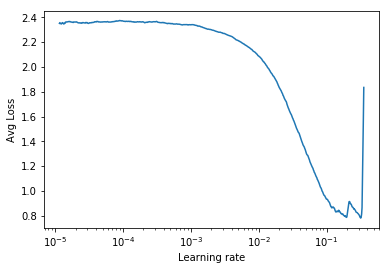

In [10]:
lr_finder.plot_avg_loss()

The optimal learning rate is in the part of the graph where the slope is the steepest, here between 2e-2 and 1e-1. We want to take the highest learning rate without taking too much risks (close from the minimum). A good value seems to be 7e-2.

## Cyclical Learning Rate and Momentum

In [11]:
clr = CLR(min_lr=7e-3, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01,
          training_iterations=np.ceil(((X_train.shape[0]*epochs)/(batch_size))))
model = Net()

In [12]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 18s 304us/step - loss: 0.4301 - acc: 0.8716 - val_loss: 0.1516 - val_acc: 0.9517
Epoch 2/5
60000/60000 [==============================] - 18s 308us/step - loss: 0.1456 - acc: 0.9559 - val_loss: 0.1046 - val_acc: 0.9684
Epoch 3/5
60000/60000 [==============================] - 13s 217us/step - loss: 0.1014 - acc: 0.9687 - val_loss: 0.0763 - val_acc: 0.9769
Epoch 4/5
60000/60000 [==============================] - 14s 232us/step - loss: 0.0726 - acc: 0.9772 - val_loss: 0.0636 - val_acc: 0.9786
Epoch 5/5
60000/60000 [==============================] - 18s 306us/step - loss: 0.0486 - acc: 0.9850 - val_loss: 0.0571 - val_acc: 0.9817


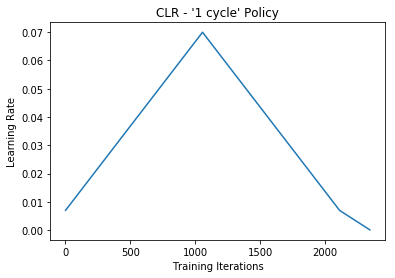

In [15]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - '1 cycle' Policy")
plt.plot(clr.history['iterations'], clr.history['lr'])

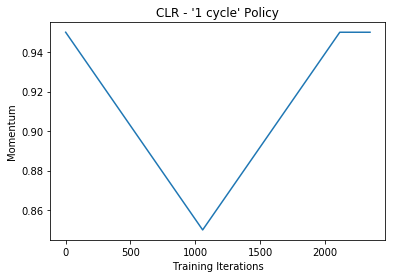

In [16]:
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("CLR - '1 cycle' Policy")
plt.plot(clr.history['iterations'], clr.history['momentum'])

## Stochastic Gradient Descent with Restart (SGDR)

In [17]:
sgdr = SGDR(min_lr=7e-3,max_lr=7e-2,step_size=np.ceil(X_train.shape[0]/batch_size), lr_decay=0.9, mult_factor=1.5)
model = Net()

In [18]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[sgdr])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 194us/step - loss: 0.5491 - acc: 0.8457 - val_loss: 0.3026 - val_acc: 0.9147
Epoch 2/5
60000/60000 [==============================] - 13s 216us/step - loss: 0.3126 - acc: 0.9095 - val_loss: 0.2262 - val_acc: 0.9347
Epoch 3/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.2572 - acc: 0.9249 - val_loss: 0.1977 - val_acc: 0.9429
Epoch 4/5
60000/60000 [==============================] - 10s 175us/step - loss: 0.2175 - acc: 0.9368 - val_loss: 0.1699 - val_acc: 0.9489
Epoch 5/5
60000/60000 [==============================] - 13s 220us/step - loss: 0.1966 - acc: 0.9430 - val_loss: 0.1642 - val_acc: 0.9516


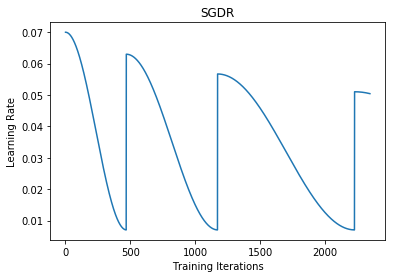

In [19]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("SGDR")
plt.plot(sgdr.history['iterations'], sgdr.history['lr'])

## Cyclical Learning Rate (CLR)

In [20]:
clr_triangular = CyclicLR(min_lr=7e-3, max_lr=7e-2, mode='triangular', step_size=np.ceil((X_train.shape[0]/batch_size)))
model = Net()

In [21]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 167us/step - loss: 0.9205 - acc: 0.7429 - val_loss: 0.2957 - val_acc: 0.9178
Epoch 2/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.3083 - acc: 0.9098 - val_loss: 0.2279 - val_acc: 0.9366
Epoch 3/5
60000/60000 [==============================] - 13s 223us/step - loss: 0.2602 - acc: 0.9240 - val_loss: 0.2083 - val_acc: 0.9373
Epoch 4/5
60000/60000 [==============================] - 13s 215us/step - loss: 0.2135 - acc: 0.9382 - val_loss: 0.1662 - val_acc: 0.9524
Epoch 5/5
60000/60000 [==============================] - 11s 183us/step - loss: 0.1897 - acc: 0.9453 - val_loss: 0.1506 - val_acc: 0.9545


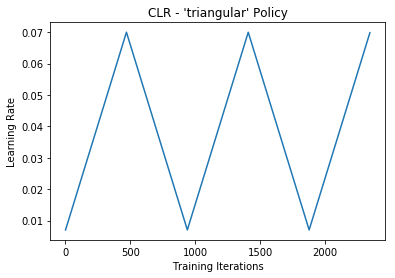

In [22]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [23]:
clr_triangular = CyclicLR(min_lr=7e-3, max_lr=7e-2, mode='triangular2', step_size=np.ceil(X_train.shape[0]/batch_size))
model = Net()

In [24]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data= (X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 174us/step - loss: 0.9267 - acc: 0.7413 - val_loss: 0.3030 - val_acc: 0.9152
Epoch 2/5
60000/60000 [==============================] - 10s 171us/step - loss: 0.3086 - acc: 0.9104 - val_loss: 0.2302 - val_acc: 0.9347
Epoch 3/5
60000/60000 [==============================] - 13s 213us/step - loss: 0.2655 - acc: 0.9239 - val_loss: 0.2083 - val_acc: 0.9389
Epoch 4/5
60000/60000 [==============================] - 12s 197us/step - loss: 0.2328 - acc: 0.9330 - val_loss: 0.1865 - val_acc: 0.9461
Epoch 5/5
60000/60000 [==============================] - 13s 214us/step - loss: 0.2168 - acc: 0.9372 - val_loss: 0.1767 - val_acc: 0.9487


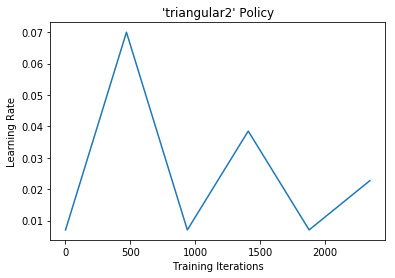

In [25]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [26]:
clr_triangular._reset()

In [27]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 188us/step - loss: 0.2038 - acc: 0.9408 - val_loss: 0.1584 - val_acc: 0.9523
Epoch 2/5
60000/60000 [==============================] - 15s 251us/step - loss: 0.1745 - acc: 0.9483 - val_loss: 0.1394 - val_acc: 0.9573
Epoch 3/5
60000/60000 [==============================] - 16s 260us/step - loss: 0.1608 - acc: 0.9535 - val_loss: 0.1346 - val_acc: 0.9585
Epoch 4/5
60000/60000 [==============================] - 15s 248us/step - loss: 0.1505 - acc: 0.9557 - val_loss: 0.1253 - val_acc: 0.9606
Epoch 5/5
60000/60000 [==============================] - 12s 202us/step - loss: 0.1449 - acc: 0.9581 - val_loss: 0.1214 - val_acc: 0.9624


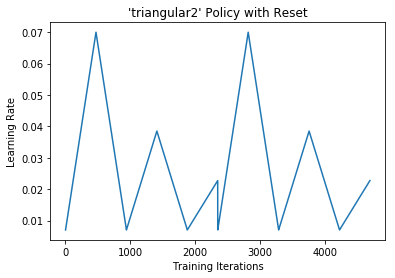

In [28]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy with Reset")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [29]:
clr_triangular = CyclicLR(mode='exp_range', step_size=np.ceil(X_train.shape[0]/batch_size), gamma=0.9994)
model = Net()

In [30]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 190us/step - loss: 1.9249 - acc: 0.3989 - val_loss: 1.1018 - val_acc: 0.7977
Epoch 2/5
60000/60000 [==============================] - 11s 187us/step - loss: 0.8775 - acc: 0.7865 - val_loss: 0.6637 - val_acc: 0.8578
Epoch 3/5
60000/60000 [==============================] - 12s 194us/step - loss: 0.7215 - acc: 0.8139 - val_loss: 0.5458 - val_acc: 0.8729
Epoch 4/5
60000/60000 [==============================] - 13s 210us/step - loss: 0.6000 - acc: 0.8358 - val_loss: 0.4871 - val_acc: 0.8806
Epoch 5/5
60000/60000 [==============================] - 14s 232us/step - loss: 0.5732 - acc: 0.8418 - val_loss: 0.4590 - val_acc: 0.8843


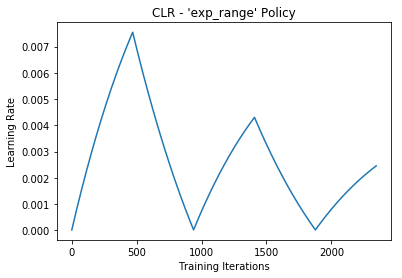

In [31]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'exp_range' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [32]:
clr_triangular._reset(new_min_lr=0.003, new_step_size=np.ceil(X_train.shape[0]/batch_size), new_max_lr=0.009)

In [33]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 191us/step - loss: 0.5156 - acc: 0.8545 - val_loss: 0.3895 - val_acc: 0.8956
Epoch 2/5
60000/60000 [==============================] - 11s 188us/step - loss: 0.4506 - acc: 0.8698 - val_loss: 0.3542 - val_acc: 0.9030
Epoch 3/5
60000/60000 [==============================] - 11s 189us/step - loss: 0.4196 - acc: 0.8803 - val_loss: 0.3329 - val_acc: 0.9069
Epoch 4/5
60000/60000 [==============================] - 11s 182us/step - loss: 0.3968 - acc: 0.8855 - val_loss: 0.3185 - val_acc: 0.9092
Epoch 5/5
60000/60000 [==============================] - 12s 193us/step - loss: 0.3810 - acc: 0.8903 - val_loss: 0.3070 - val_acc: 0.9138


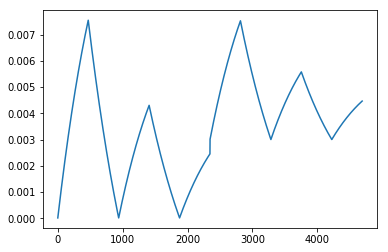

In [34]:
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [35]:
clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))

In [36]:
clr_triangular = CyclicLR(min_lr=7e-3, max_lr=7e-2, scale_fn=clr, scale_mode='cycle', step_size=np.ceil(X_train.shape[0]/batch_size))
model = Net()

In [37]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 173us/step - loss: 0.9230 - acc: 0.7427 - val_loss: 0.3095 - val_acc: 0.9112
Epoch 2/5
60000/60000 [==============================] - 9s 154us/step - loss: 0.3121 - acc: 0.9102 - val_loss: 0.2312 - val_acc: 0.9337
Epoch 3/5
60000/60000 [==============================] - 10s 162us/step - loss: 0.2678 - acc: 0.9219 - val_loss: 0.2097 - val_acc: 0.9402
Epoch 4/5
60000/60000 [==============================] - 11s 184us/step - loss: 0.2383 - acc: 0.9307 - val_loss: 0.1883 - val_acc: 0.9471
Epoch 5/5
60000/60000 [==============================] - 11s 179us/step - loss: 0.2218 - acc: 0.9354 - val_loss: 0.1817 - val_acc: 0.9480


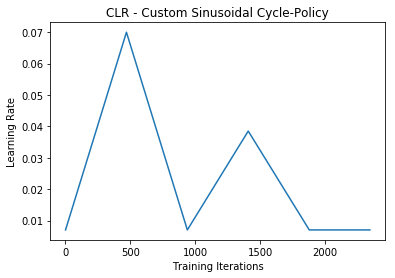

In [38]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Sinusoidal Cycle-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [8]:
clr = lambda x: 1/(5**(x*0.0001))

In [9]:
clr_triangular = CyclicLR(min_lr=7e-3, max_lr=7e-2, scale_fn=clr, scale_mode='iterations', step_size=np.ceil(X_train.shape[0]/batch_size))
model = Net()

In [10]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 179us/step - loss: 0.9184 - acc: 0.7428 - val_loss: 0.3100 - val_acc: 0.9142
Epoch 2/5
60000/60000 [==============================] - 12s 208us/step - loss: 0.3175 - acc: 0.9084 - val_loss: 0.2386 - val_acc: 0.9315
Epoch 3/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.2710 - acc: 0.9215 - val_loss: 0.2077 - val_acc: 0.9401
Epoch 4/5
60000/60000 [==============================] - 10s 166us/step - loss: 0.2284 - acc: 0.9334 - val_loss: 0.1797 - val_acc: 0.9475
Epoch 5/5
60000/60000 [==============================] - 10s 167us/step - loss: 0.2082 - acc: 0.9390 - val_loss: 0.1645 - val_acc: 0.9506


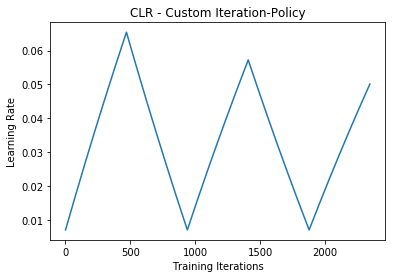

In [11]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Iteration-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])